In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer



In [3]:
data = pd.read_csv('reviews.csv')


In [4]:
data.shape

(3572, 5)

In [5]:
data.status.value_counts()

good       1541
neutral    1118
bad         913
Name: status, dtype: int64

In [6]:
data=data.groupby('status',as_index = False,group_keys=False).apply(lambda s: s.sample(913,replace=True))

In [7]:
data.status.value_counts()

bad        913
good       913
neutral    913
Name: status, dtype: int64

In [8]:
from sklearn.utils import shuffle
data = shuffle(data)

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from pymystem3 import Mystem
from string import punctuation
from nltk.stem.snowball import SnowballStemmer 
#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(text):
    text = (lambda f: re.sub(r'\d|\W', ' ', text))(text)
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation\
              and len(token) > 3]
    text = " ".join(tokens)
    
    return text


data['review'] = [(lambda f: preprocess_text(text))(text) for text in data['review']]


In [10]:
X = data.review
y = data.status

In [11]:
from sklearn.model_selection import cross_val_score

In [31]:
from sklearn import metrics 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

svm_mod = make_pipeline(TfidfVectorizer(), SVC(kernel='linear', probability=True))
svm_mod.fit(x_train, y_train)
pred_svm = svm_mod.predict(x_test)
print("SVM accuracy ",metrics.accuracy_score(y_test, pred_svm))
scores_svm = cross_val_score(svm_mod, X, y, cv=5, scoring='accuracy')


SVM accuracy  0.7828467153284672


In [13]:
svm_mean = scores_svm.mean()
svm_mean

0.7747321154539024

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
log_model = make_pipeline(TfidfVectorizer(), LogisticRegression())
log_model.fit(x_train, y_train)
pred_log = log_model.predict(x_test)
print('Logistic Regression accuracy', metrics.accuracy_score(y_test, pred_log))
scores_log = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')
log_mean = scores_log.mean()
log_mean

Logistic Regression accuracy 0.7718978102189781


0.7736365577336234

In [17]:
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_model.fit(x_train, y_train)
pred_nb = nb_model.predict(x_test)
scores_nb = cross_val_score(nb_model, X, y, cv=5, scoring='accuracy')
nb_mean = scores_nb.mean()
print('Naive Bayes accuracy', metrics.accuracy_score(y_test, pred_nb))
print(nb_mean)

tree = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
tree.fit(x_train,y_train)
tree_pred = tree.predict(x_test)
scores_tree = cross_val_score(tree, X, y, cv=5, scoring='accuracy')
tree_mean = scores_tree.mean()
tree_mean
print('Decision Tree accuracy', metrics.accuracy_score(y_test, tree_pred))
print(tree_mean)

Naive Bayes accuracy 0.7572992700729927
0.7462602917039192
Decision Tree accuracy 0.6952554744525548
0.6911161077676511


Maximum accuracy: 0.6988076969268338 at K = 1


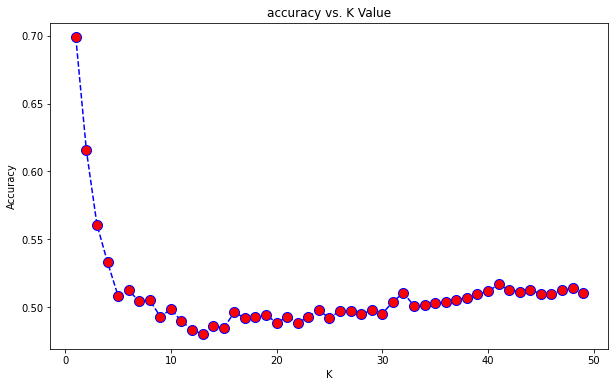

In [18]:
acc = []
for k in range(1, 50):
    knn = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=k))
    scores_knn = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    knn_mean = scores_knn.mean()
    acc.append(knn_mean)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,50),acc,color = 'blue',linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

In [19]:
k = acc.index(max(acc))+1
knn = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=k))
knn.fit(x_train, y_train)
pred_knn = knn.predict(x_test)
scores_knn = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
knn_mean = scores_knn.mean()
print('KNN accuracy', metrics.accuracy_score(y_test, pred_knn))
knn_mean

KNN accuracy 0.6916058394160584


0.6988076969268338

In [23]:
rf_model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
rf_model.fit(x_train, y_train)
pred_rf = rf_model.predict(x_test)
print('Random Forest accuracy', metrics.accuracy_score(y_test, pred_rf))
scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
rf_mean = scores_rf.mean()


Random Forest accuracy 0.7974452554744526


In [24]:
rf_mean

0.7696099494255328

In [30]:
#Precision 
logm_precision = metrics.precision_score(y_test, pred_log, average='micro')
nb_precision = metrics.precision_score(y_test, pred_nb, average='micro')
svc_precision = metrics.precision_score(y_test, pred_svm, average='micro')
knn_precision = metrics.precision_score(y_test, pred_knn, average='micro')
dt_precision = metrics.precision_score(y_test, tree_pred, average='micro')
rf_precision = metrics.precision_score(y_test, pred_rf, average='micro')

#Recall 
logm_recall = metrics.recall_score(y_test, pred_log, average='micro')
nb_recall = metrics.recall_score(y_test, pred_nb, average='micro')
svc_recall = metrics.recall_score(y_test, pred_svm, average='micro')
knn_recall = metrics.recall_score(y_test, pred_knn, average='micro')
dt_recall = metrics.recall_score(y_test, tree_pred, average='micro')
rf_recall = metrics.recall_score(y_test, pred_rf, average='micro')

#F1-measure
logm_f1 = metrics.fbeta_score(y_test, pred_log, beta=1.0, average='micro')
nb_f1 = metrics.fbeta_score(y_test, pred_nb, beta=1.0, average='micro')
svc_f1 = metrics.fbeta_score(y_test, pred_svm, beta=1.0, average='micro')
knn_f1 = metrics.fbeta_score(y_test, pred_knn, beta=1.0, average='micro')
dt_f1 = metrics.fbeta_score(y_test, tree_pred, beta=1.0, average='micro')
rf_f1 = metrics.fbeta_score(y_test, pred_rf, beta=1.0, average='micro')

#compare models accross classification metrics
Model_Comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'K-Nearest Neighbor', 
              'Decision Tree', 'Random Forest'],
    'Accuracy': [log_mean, nb_mean, svm_mean, knn_mean, tree_mean, rf_mean],
    'Precision': [logm_precision,nb_precision, svc_precision, knn_precision, dt_precision, rf_precision],
    'Recall': [logm_recall, nb_recall, svc_recall, knn_recall, dt_recall, rf_recall],
    'F1-meas.': [logm_f1, nb_f1, svc_f1, knn_f1, dt_f1, rf_f1]})
Model_Comparison.round(4)

,Model,Accuracy,Precision,Recall,F1-meas.
0,Logistic Regression,0.7736,0.7719,0.7719,0.7719
1,Naive Bayes,0.7463,0.7573,0.7573,0.7573
2,Support Vector Machine,0.7747,0.7828,0.7828,0.7828
3,K-Nearest Neighbor,0.6988,0.6916,0.6916,0.6916
4,Decision Tree,0.6911,0.6953,0.6953,0.6953
5,Random Forest,0.7696,0.7974,0.7974,0.7974


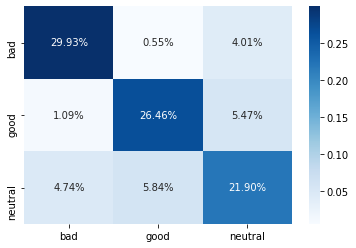

In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np

conf_mat = confusion_matrix(y_test, pred_svm)
ax = sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues')
ax.xaxis.set_ticklabels(['bad', 'good', 'neutral'])
ax.yaxis.set_ticklabels(['bad', 'good', 'neutral'])
plt.show()


In [14]:
import pickle 

svmFile = open('svm_final.pckl', 'wb')
pickle.dump(svm_mod, svmFile)
svmFile.close()

In [13]:
text = '''Всё что было интересно в первых фильмах о Пауке в данной трилогии - выпилили. Нет-нет! Блюдо всё то же, только подано оно под каким-то пресным соусом. Создатели те же, но больше нет интересных диалогов, нет колоритных злодеев и нет комичных ситуаций, в которые попадал бы главный герой, а сам сценарий деградировал до уровня 'и так сойдет'.

Суетливая болтовня Питера Паркера в первых фильмах забавляла, потому что это был подросток, который вел себя соответствующе - как ребенок. Но в данном творении эта особенность уже порядком раздражала. Главный герой не меняется от слова 'совсем', хотя пережил уже больше чем любой другой человек за всю жизнь. А еще актер изрядно возмужал, от чего всё это бросается в глаза еще сильнее.'''

new_text = preprocess_text(text)
svm_mod.predict([new_text])

array(['bad'], dtype=object)